# **FROM SCRATCH WITHOUT PRETRAINED**

In [27]:
import zipfile
import os

zip_file_path = '/content/drive/MyDrive/archive (4).zip'
extracted_path = '/content/FaceMask'

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_path)


In [28]:
import glob
dataset = glob.glob('/content/FaceMask/data')
images_path = glob.glob('/content/FaceMask/data/*/*.*')
images_path[:4]

['/content/FaceMask/data/without_mask/without_mask_29.jpg',
 '/content/FaceMask/data/without_mask/without_mask_3114.jpg',
 '/content/FaceMask/data/without_mask/without_mask_3280.jpg',
 '/content/FaceMask/data/without_mask/without_mask_2476.jpg']

In [29]:
face_mask_dir = {
    'with_mask': glob.glob('/content/FaceMask/data/with_mask/*.*'),
    'without_mask': glob.glob('/content/FaceMask/data/without_mask/*.*')
}

In [30]:
face_mask_labels = {
    'with_mask': 0,
    'without_mask': 1
}

In [31]:
import cv2
x, y = [], []
for label, images in face_mask_dir.items():
  for image in images:
    img = cv2.imread(str(image))
    img = cv2.resize(img, (64,64))
    x.append(img)
    y.append(face_mask_labels[label])

In [32]:
import numpy as np
x = np.array(x)
y = np.array(y)

In [33]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [34]:
x_train = x_train / 255.0
x_test = x_test / 255.0

In [35]:
import tensorflow as tf
from tensorflow import keras


In [36]:
x_train.shape

(6042, 64, 64, 3)

In [37]:
data_augmentation = keras.Sequential([
    keras.layers.RandomFlip('horizontal'),
    keras.layers.RandomRotation(0.2)
])

In [40]:
model = keras.Sequential([
    # data_augmentation,
    keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(64,64,3)),
    keras.layers.MaxPooling2D((2,2)),
    keras.layers.Conv2D(64, (3,3), activation='relu'),
    keras.layers.MaxPooling2D((2,2)),
    keras.layers.Conv2D(128, (3,3), activation='relu'),
    keras.layers.MaxPooling2D((2,2)),
    keras.layers.Conv2D(128, (3,3), activation='relu'),
    keras.layers.MaxPooling2D((2,2)),
    keras.layers.Flatten(),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [41]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)
model.fit(x_train, y_train, epochs=5, validation_data=(x_test, y_test))

Epoch 1/5
189/189 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.7353 - loss: 0.4769 - val_accuracy: 0.9186 - val_loss: 0.1972
Epoch 2/5
189/189 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9370 - loss: 0.1726 - val_accuracy: 0.9444 - val_loss: 0.1429
Epoch 3/5
189/189 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9555 - loss: 0.1288 - val_accuracy: 0.9497 - val_loss: 0.1203
Epoch 4/5
189/189 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9613 - loss: 0.1080 - val_accuracy: 0.9537 - val_loss: 0.1263
Epoch 5/5
189/189 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9764 - loss: 0.0776 - val_accuracy: 0.9616 - val_loss: 0.1045


In [42]:
model.evaluate(x_test, y_test)

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9570 - loss: 0.1012


[0.10447113960981369, 0.9616148471832275]

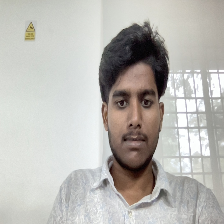

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
without mask and accuracy -  [[0.9740664]]


In [50]:
from google.colab.patches import cv2_imshow
img = cv2.imread('/content/Photo on 15-05-25 at 3.16 PM.jpg')
cv2_imshow(cv2.resize(img, (224,224)))
img = cv2.resize(img, (64,64))
img = img / 255.0
img = np.expand_dims(img, axis=0)
y = model.predict(img)
if(y >= 0.5):
  print('without mask and accuracy - ',y)
else:
  print('with mask and accuracy - ',y)

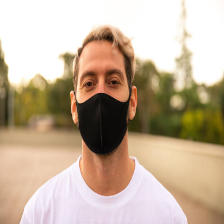

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
with mask and accuracy -  [[0.00100628]]


In [51]:
img = cv2.imread('/content/image.jpg')
cv2_imshow(cv2.resize(img, (224,224)))
img = cv2.resize(img, (64,64))
img = cv2.resize(img, (64,64))
img = img / 255.0
img = np.expand_dims(img, axis=0)
y = model.predict(img)
if(y >= 0.5):
  print('without mask and accuracy - ',y)
else:
  print('with mask and accuracy - ',y)

##**USING PRETRAINED MODEL (MOBILENETV2)**

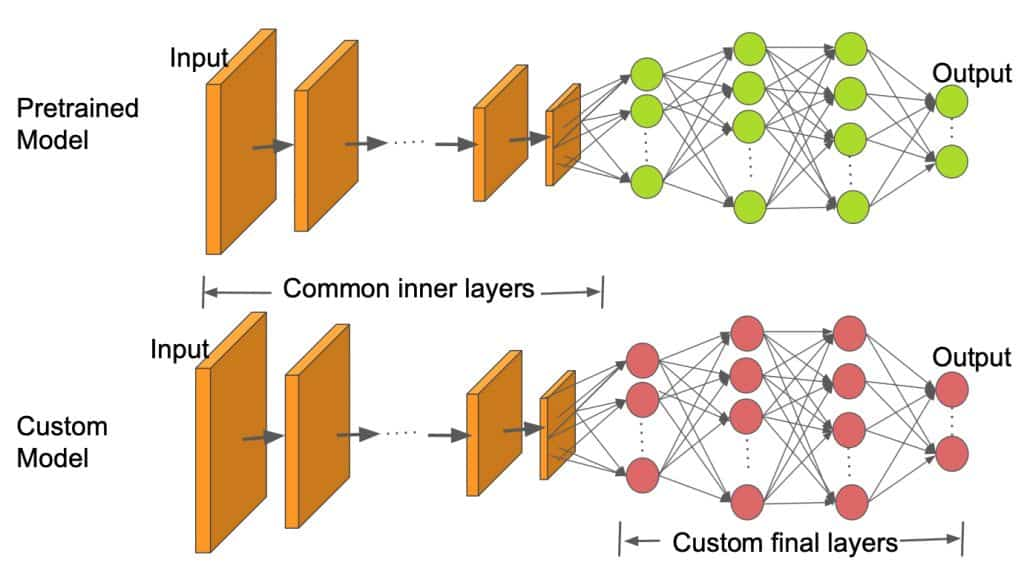

In [66]:
img = cv2.imread('/content/transfer-learning-1024x574.jpg')
cv2_imshow(img)

In [67]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 1. Load Pretrained Model (without top)
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3)) #include_top means remove the last layer output

# 2. Freeze base layers
base_model.trainable = False # all green color nodes

# 3. Add custom head
x = base_model.output #🟧 This is the output of the pretrained convolutional base (orange layers).
x = GlobalAveragePooling2D()(x) #🔴 This is the first layer of your custom classifier head (red circles).
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)
predictions = Dense(2, activation='softmax')(x)  # Assuming mask vs no mask. Last 2 nodes of red color

model = Model(inputs=base_model.input, outputs=predictions)

# 4. Compile
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
#at 1st compile only compile 🔴 nodes
# 5. Prepare data
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = train_datagen.flow_from_directory(
    '/content/FaceMask/data',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

val_generator = train_datagen.flow_from_directory(
    '/content/FaceMask/data',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

# 6. Train
model.fit(train_generator, validation_data=val_generator, epochs=5)

Found 6043 images belonging to 2 classes.
Found 1510 images belonging to 2 classes.
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


 33/189 ━━━━━━━━━━━━━━━━━━━━ 11s 75ms/step - accuracy: 0.8345 - loss: 0.3638

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


189/189 ━━━━━━━━━━━━━━━━━━━━ 35s 135ms/step - accuracy: 0.9323 - loss: 0.1589 - val_accuracy: 0.9795 - val_loss: 0.0552
Epoch 2/5
189/189 ━━━━━━━━━━━━━━━━━━━━ 17s 92ms/step - accuracy: 0.9905 - loss: 0.0317 - val_accuracy: 0.9907 - val_loss: 0.0300
Epoch 3/5
189/189 ━━━━━━━━━━━━━━━━━━━━ 17s 89ms/step - accuracy: 0.9900 - loss: 0.0284 - val_accuracy: 0.9894 - val_loss: 0.0266
Epoch 4/5
189/189 ━━━━━━━━━━━━━━━━━━━━ 21s 90ms/step - accuracy: 0.9944 - loss: 0.0158 - val_accuracy: 0.9907 - val_loss: 0.0341
Epoch 5/5
189/189 ━━━━━━━━━━━━━━━━━━━━ 23s 102ms/step - accuracy: 0.9942 - loss: 0.0167 - val_accuracy: 0.9781 - val_loss: 0.0696


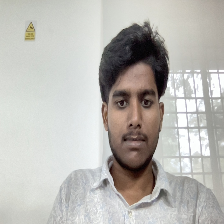

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
[[2.4827236e-07 9.9999976e-01]]


In [68]:
from google.colab.patches import cv2_imshow
img = cv2.imread('/content/Photo on 15-05-25 at 3.16 PM.jpg')
cv2_imshow(cv2.resize(img, (224,224)))
img = cv2.resize(img, (224,224))
img = img / 255.0
img = np.expand_dims(img, axis=0)
y = model.predict(img)
print(y)

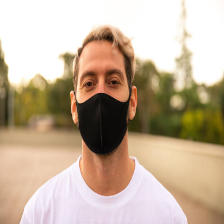

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
[[9.9973541e-01 2.6462486e-04]]


In [69]:
img = cv2.imread('/content/image.jpg')
cv2_imshow(cv2.resize(img, (224,224)))
img = cv2.resize(img, (224,224))
img = img / 255.0
img = np.expand_dims(img, axis=0)
y = model.predict(img)
print(y)